In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip install clip

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6988 sha256=9222fd90682950fa8b39aa4ad3c21c4031fe683b649c0dc5b6f0947e66eefec7
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip


In [3]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.4 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, Dataset
import faiss
import warnings
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from torch.optim import Adam

warnings.filterwarnings('ignore')

# CNN-based feature extractor
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, output_dim)

    def forward(self, x):
        return self.model(x)


In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (64, 28, 28)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


In [8]:
class TraditionalFeatureExtractor:
    def __init__(self, method='sift'):
        self.method = method
        if method == 'sift':
            self.detector = cv2.SIFT_create()
        else:  # ORB
            self.detector = cv2.ORB_create()

    def extract(self, image):
        if isinstance(image, torch.Tensor):
            image = (image.cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)
        elif isinstance(image, Image.Image):
            image = np.array(image)

        # Convert to grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image

        keypoints, descriptors = self.detector.detectAndCompute(gray, None)
        return keypoints, descriptors

    def match_features(self, desc1, desc2):
        if desc1 is None or desc2 is None:
            return []

        if self.method == 'sift':
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        else:  # ORB
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        matches = bf.match(desc1, desc2)
        matches = sorted(matches, key=lambda x: x.distance)
        return matches[:50]  # Return top 50 matches

In [9]:
class ImageSearchSystem:
    def __init__(self, dataset_size=1000):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Initialize models
        self.cnn = CNNFeatureExtractor().to(self.device)
        self.autoencoder = Autoencoder().to(self.device)
        self.sift_extractor = TraditionalFeatureExtractor('sift')
        self.orb_extractor = TraditionalFeatureExtractor('orb')

        # Initialize FAISS indexes
        self.indexes = {
            'cnn': faiss.IndexFlatL2(128),
            'autoencoder': faiss.IndexFlatL2(128)
        }

        # Storage
        self.dataset_size = dataset_size
        self.features = {'cnn': [], 'autoencoder': []}
        self.traditional_features = {'sift': {}, 'orb': {}}
        self.labels = []
        self.images = []
        self.class_names = []

    def prepare_data(self):
        """Prepare CIFAR-10 dataset"""
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        trainset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform
        )

        # Use subset for demonstration
        indices = torch.randperm(len(trainset))[:self.dataset_size]
        subset = Subset(trainset, indices)

        self.class_names = trainset.classes
        self.dataloader = DataLoader(subset, batch_size=32, shuffle=False)
        print(f"Prepared dataset with {self.dataset_size} images from CIFAR-10")

        return self.dataloader

    def train(self, trainloader, epochs=10, lr=1e-3):
        """Training loop for CNN and Autoencoder"""
        cnn_optimizer = Adam(self.cnn.parameters(), lr=lr)
        ae_optimizer = Adam(self.autoencoder.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.cnn.train()
            self.autoencoder.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in tqdm(trainloader, desc=f"Training Epoch {epoch+1}/{epochs}"):
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Zero the parameter gradients
                cnn_optimizer.zero_grad()
                ae_optimizer.zero_grad()

                # CNN model
                cnn_outputs = self.cnn(images)
                loss = criterion(cnn_outputs, labels)
                loss.backward()
                cnn_optimizer.step()

                # Track accuracy
                _, predicted = torch.max(cnn_outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                running_loss += loss.item()

            accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")

    def extract_features(self):
        """Extract features using all approaches"""
        self.cnn.eval()
        self.autoencoder.eval()

        for batch_idx, (images, labels) in enumerate(tqdm(self.dataloader, desc="Extracting features")):
            images = images.to(self.device)
            labels = labels.numpy()

            # Store original images and labels
            self.images.extend(images.cpu().numpy())
            self.labels.extend(labels)

            # Extract deep learning features
            with torch.no_grad():
                # CNN features
                cnn_features = self.cnn(images)
                self.features['cnn'].append(cnn_features.cpu().numpy())

                # Autoencoder features
                _, ae_features = self.autoencoder(images)
                self.features['autoencoder'].append(ae_features.cpu().numpy())

            # Extract traditional features
            for img_idx, img in enumerate(images):
                img_np = (img.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

                # SIFT features
                _, desc_sift = self.sift_extractor.extract(img_np)
                if desc_sift is not None:
                    self.traditional_features['sift'][batch_idx * 32 + img_idx] = desc_sift

                # ORB features
                _, desc_orb = self.orb_extractor.extract(img_np)
                if desc_orb is not None:
                    self.traditional_features['orb'][batch_idx * 32 + img_idx] = desc_orb

    def build_indexes(self):
        """Add features to FAISS indexes"""
        # Flatten the feature arrays
        cnn_features = np.vstack(self.features['cnn']).astype('float32')
        autoencoder_features = np.vstack(self.features['autoencoder']).astype('float32')

        # Add features to FAISS index
        self.indexes['cnn'].add(cnn_features)
        self.indexes['autoencoder'].add(autoencoder_features)



# In the 'evaluate' method:
    def evaluate(self, dataloader):
        """Evaluate CNN, Autoencoder, and Traditional methods using accuracy"""
        all_labels = []
        cnn_preds = []
        ae_preds = []
        traditional_preds = {'sift': [], 'orb': []}

        # Aggregated descriptors for SIFT/ORB
        sift_descriptors = []
        orb_descriptors = []

        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="Evaluating Models"):
                images = images.to(self.device)
                labels = labels.numpy()

                # Collect the true labels
                all_labels.extend(labels)

                # CNN prediction
                cnn_outputs = self.cnn(images)
                _, cnn_predicted = torch.max(cnn_outputs, 1)
                cnn_preds.extend(cnn_predicted.cpu().numpy())

                # Autoencoder prediction
                _, ae_features = self.autoencoder(images)
                ae_preds.extend(np.argmax(ae_features.cpu().numpy(), axis=1))

                # Traditional (SIFT & ORB) feature extraction
                for img_idx, img in enumerate(images):
                    img_np = (img.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

                    # SIFT features
                    _, desc_sift = self.sift_extractor.extract(img_np)
                    if desc_sift is not None:
                        sift_descriptors.append(np.mean(desc_sift, axis=0))  # Average descriptors for KNN

                    # ORB features
                    _, desc_orb = self.orb_extractor.extract(img_np)
                    if desc_orb is not None:
                        orb_descriptors.append(np.mean(desc_orb, axis=0))  # Average descriptors for KNN


        sift_descriptors = np.array(sift_descriptors)
        orb_descriptors = np.array(orb_descriptors)

        #KNN to classify traditional features (SIFT and ORB)
        if len(sift_descriptors) > 0:
            knn_sift = KNeighborsClassifier(n_neighbors=5)
            knn_sift.fit(sift_descriptors, all_labels)
            sift_preds = knn_sift.predict(sift_descriptors)
            sift_accuracy = accuracy_score(all_labels, sift_preds)
            print(f"SIFT Accuracy: {sift_accuracy * 100:.2f}%")

        if len(orb_descriptors) > 0:
            knn_orb = KNeighborsClassifier(n_neighbors=5)
            knn_orb.fit(orb_descriptors, all_labels)
            orb_preds = knn_orb.predict(orb_descriptors)
            orb_accuracy = accuracy_score(all_labels, orb_preds)
            print(f"ORB Accuracy: {orb_accuracy * 100:.2f}%")

        #accuracy for CNN and Autoencoder
        cnn_accuracy = accuracy_score(all_labels, cnn_preds)
        ae_accuracy = accuracy_score(all_labels, ae_preds)

        print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")
        print(f"Autoencoder Accuracy: {ae_accuracy * 100:.2f}%")



    def search(self, query_image, k=5):
        """Search using all approaches"""
        results = {}

        query_image = query_image.to(self.device)

        # Deep learning approache
        with torch.no_grad():
            # CNN search
            cnn_features = self.cnn(query_image)
            cnn_features = cnn_features.cpu().numpy().astype('float32')
            distances, indices = self.indexes['cnn'].search(cnn_features, k)
            results['cnn'] = {
                'indices': indices[0],
                'distances': distances[0],
                'labels': [self.labels[idx] for idx in indices[0]]
            }

            # Autoencoder search
            _, ae_features = self.autoencoder(query_image)
            ae_features = ae_features.cpu().numpy().astype('float32')
            distances, indices = self.indexes['autoencoder'].search(ae_features, k)
            results['autoencoder'] = {
                'indices': indices[0],
                'distances': distances[0],
                'labels': [self.labels[idx] for idx in indices[0]]
            }

        # Traditional approaches
        query_np = (query_image[0].cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

        for method in ['sift', 'orb']:
            extractor = self.sift_extractor if method == 'sift' else self.orb_extractor
            _, desc_query = extractor.extract(query_np)

            if desc_query is not None:
                matches = []
                for idx, desc_db in self.traditional_features[method].items():
                    good_matches = extractor.match_features(desc_query, desc_db)
                    matches.append((idx, len(good_matches)))

                matches.sort(key=lambda x: x[1], reverse=True)
                top_k = matches[:k]

                results[method] = {
                    'indices': [idx for idx, _ in top_k],
                    'distances': [count for _, count in top_k],
                    'labels': [self.labels[idx] for idx, _ in top_k]
                }

        return results



    def visualize_results(self, query_image, results):
        methods = list(results.keys())
        n_methods = len(methods)

        plt.figure(figsize=(20, 4 * n_methods))

        for i, method in enumerate(methods):
            #query image
            plt.subplot(n_methods, 6, i * 6 + 1)
            plt.imshow(query_image[0].cpu().numpy().transpose(1, 2, 0))
            plt.title('Query Image')
            plt.axis('off')

            # Showing results for each method
            for j in range(5):
                plt.subplot(n_methods, 6, i * 6 + j + 2)
                if j < len(results[method]['indices']):
                    idx = results[method]['indices'][j]
                    plt.imshow(self.images[idx].transpose(1, 2, 0))
                    class_name = self.class_names[self.labels[idx]]
                    score = results[method]['distances'][j]

                    # Label the image with method and prediction score
                    plt.title(f'{method.upper()}\n{class_name}\nScore: {score:.2f}')
                plt.axis('off')

            # Add (model name)
            plt.subplot(n_methods, 6, i * 6 + 1)
            plt.ylabel(f'{method.upper()} Model', size='large')

        plt.tight_layout()
        plt.show()



Initializing Image Search System...
Using device: cuda

Preparing dataset...
Files already downloaded and verified
Prepared dataset with 5000 images from CIFAR-10

Training CNN model...


Training Epoch 1/6: 100%|██████████| 157/157 [00:22<00:00,  6.96it/s]


Epoch 1/6, Loss: 1.1791, Accuracy: 60.24%


Training Epoch 2/6: 100%|██████████| 157/157 [00:22<00:00,  6.93it/s]


Epoch 2/6, Loss: 0.7123, Accuracy: 75.42%


Training Epoch 3/6: 100%|██████████| 157/157 [00:22<00:00,  7.05it/s]


Epoch 3/6, Loss: 0.5070, Accuracy: 82.70%


Training Epoch 4/6: 100%|██████████| 157/157 [00:22<00:00,  6.98it/s]


Epoch 4/6, Loss: 0.3619, Accuracy: 87.14%


Training Epoch 5/6: 100%|██████████| 157/157 [00:23<00:00,  6.64it/s]


Epoch 5/6, Loss: 0.2634, Accuracy: 90.92%


Training Epoch 6/6: 100%|██████████| 157/157 [00:22<00:00,  6.92it/s]


Epoch 6/6, Loss: 0.1600, Accuracy: 94.56%

Evaluating CNN model...


Evaluating Models: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


SIFT Accuracy: 44.28%
ORB Accuracy: 38.58%
CNN Accuracy: 95.36%
Autoencoder Accuracy: 4.42%

Extracting features...


Extracting features: 100%|██████████| 157/157 [03:17<00:00,  1.26s/it]



Building search indexes...
Files already downloaded and verified
Prepared dataset with 5000 images from CIFAR-10

Performing sample search...



Visualizing results...


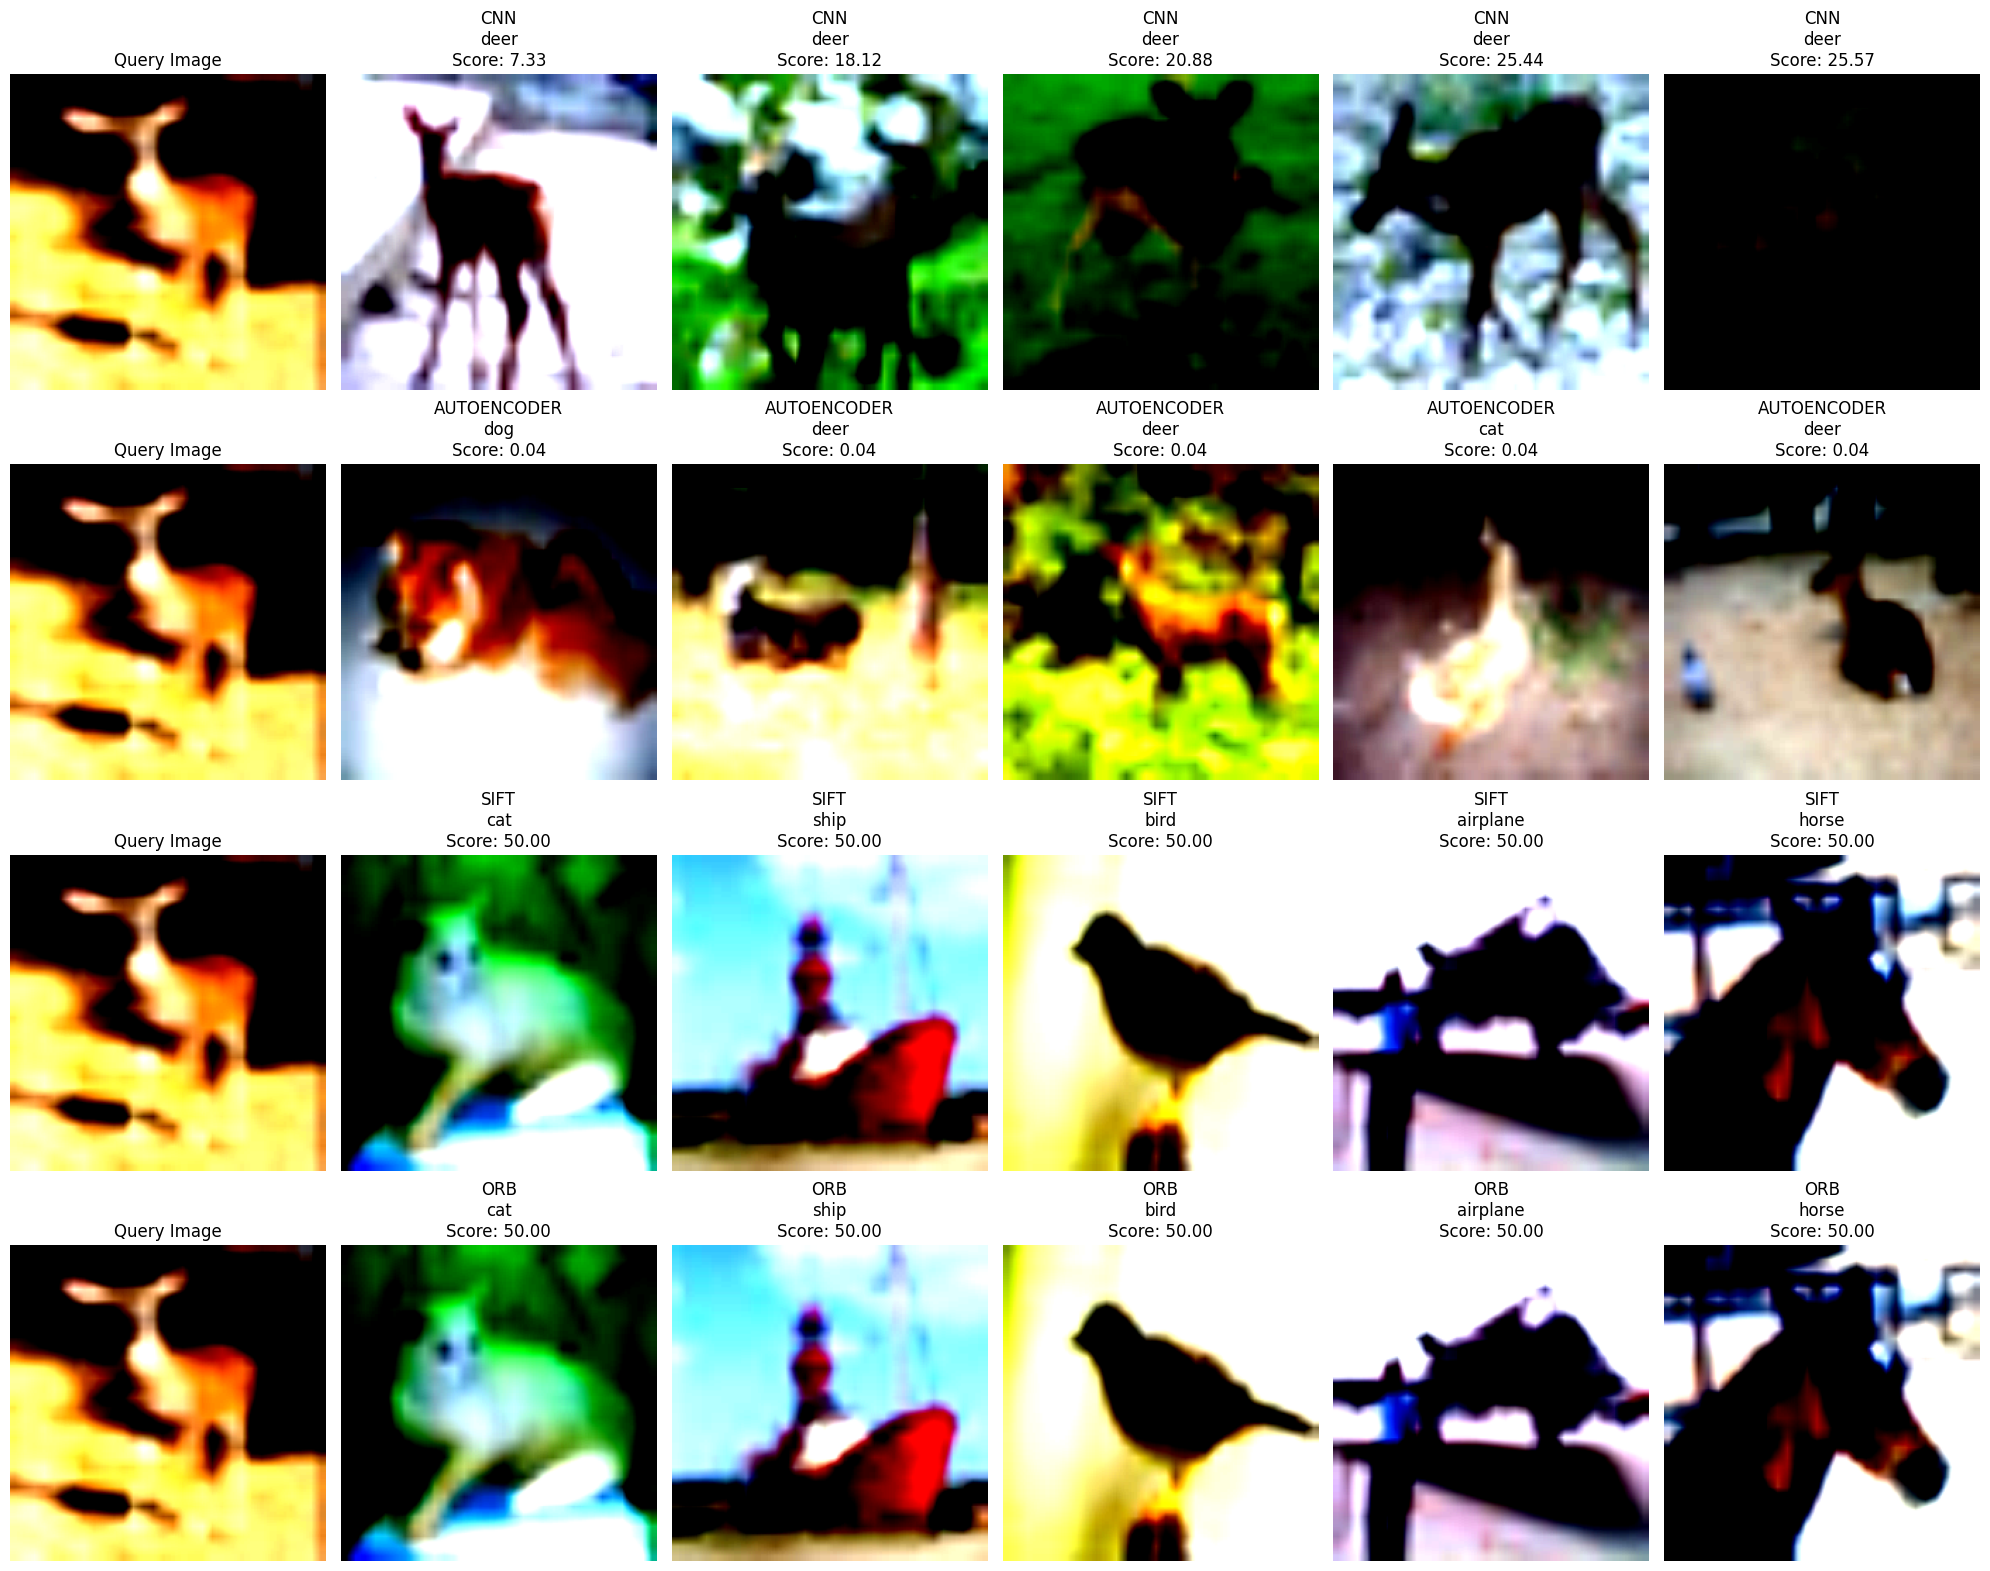

In [12]:
def main():
    # Initialize system
    print("Initializing Image Search System...")
    search_system = ImageSearchSystem(dataset_size=5000)

    # Preparing data
    print("\nPreparing dataset...")
    dataloader = search_system.prepare_data()

    # Training CNN model
    print("\nTraining CNN model...")
    search_system.train(dataloader, epochs=6)

    # Evaluating CNN model
    print("\nEvaluating CNN model...")
    search_system.evaluate(dataloader)

    # Extracting features
    print("\nExtracting features...")
    search_system.extract_features()

    print("\nBuilding search indexes...")
    search_system.build_indexes()

    dataloader = search_system.prepare_data()

    #sample search
    print("\nPerforming sample search...")
    for images, _ in dataloader:
        query_image = images[0:1]
        break

    results = search_system.search(query_image)

    #results
    print("\nVisualizing results...")
    search_system.visualize_results(query_image, results)

if __name__ == "__main__":
    main()